# Cryptocurrency Market Predictor - Recurrent Neural Network

Predicting BTCUSD market

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
dataset = pd.read_csv('BTCUSD_TechnicalIndicators.csv', nrows=5000)
dataset.tail(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
4998,4309.035,4309.035,-1.347975e-08,4309.04,0.000002,4309.03,4309.04,21.008198,9.02431,0.01
4999,4309.035,4309.035,-1.248211e-08,4309.04,0.000002,4309.03,4309.04,21.008198,6.52431,0.01


In [3]:
spotdata = pd.read_csv('BTCUSD_SPOT.csv', nrows=200)
spotdata.tail(2) 

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
198,4150.015,4150.015,0.001773,4150.02,0.000002,4150.01,4150.02,13.596676,9.96846,0.01
199,4150.015,4150.015,0.001651,4150.02,0.000002,4150.01,4150.02,13.596676,9.96846,0.01


#### Normalize

In [4]:
PriceRange=dataset["Price"].max() - dataset["Price"].min()
PriceMean = dataset["Price"].mean()
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(3)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,-0.424184,-0.425127,0.000002,-0.997099,-0.015035,-0.418556,-0.429811,-0.212539,-0.118351,-0.040523
1,-0.424184,-0.425127,0.000002,-0.997099,-0.015035,-0.418556,-0.429811,-0.212539,-0.118351,-0.040523
2,-0.424184,-0.425127,0.000002,-0.997099,-0.015035,-0.418556,-0.429811,-0.212539,-0.118351,-0.040523


In [5]:
SpotPriceRange=spotdata["Price"].max() - spotdata["Price"].min()
PriceMean = spotdata["Price"].mean()
spotdataNorm = (spotdata - spotdata.mean()) / (spotdata.max() - spotdata.min())
spotdataNorm.head(3)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,0.852344,0.868562,0.0001,0.860334,-0.014239,0.852429,0.852259,-0.156015,0.448916,-0.05
1,0.852344,0.868562,0.0001,0.860334,-0.012464,0.852429,0.852259,-0.156015,0.448916,-0.05
2,0.852344,0.868562,0.0001,0.860334,-0.014239,0.852429,0.852259,-0.156015,0.448916,-0.05


## Hyperparams

In [6]:
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 10 #The size of the sequence

state_size = 25 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 1000

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 5000
The current configuration gives us 500 batches of 1 observations each one looking 10 steps in the past


## Train-Test split

In [7]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [8]:
datasetTest = spotdataNorm

In [9]:
datasetTrain.head(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,-0.424184,-0.425127,0.000002,-0.997099,-0.015035,-0.418556,-0.429811,-0.212539,-0.118351,-0.040523
1,-0.424184,-0.425127,0.000002,-0.997099,-0.015035,-0.418556,-0.429811,-0.212539,-0.118351,-0.040523


In [10]:
datasetTest.head(2)

,Price,PriceTarget,MACD,TradePrice,trade_volume,b1,a1,bq1,aq1,Spread
0,0.852344,0.868562,0.0001,0.860334,-0.014239,0.852429,0.852259,-0.156015,0.448916,-0.05
1,0.852344,0.868562,0.0001,0.860334,-0.012464,0.852429,0.852259,-0.156015,0.448916,-0.05


In [11]:
#Pick appropriate columns to train
xTrain = datasetTrain[['Price','b1','a1','Spread']].as_matrix()
yTrain = datasetTrain['PriceTarget'].as_matrix()

In [12]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[-0.42418364 -0.41855611 -0.42981116 -0.04052325]
 [-0.42418364 -0.41855611 -0.42981116 -0.04052325]
 [-0.42418364 -0.41855611 -0.42981116 -0.04052325]] 
 [-0.42512658 -0.42512658 -0.42512658]


In [13]:
#Pick appropriate columns to test
xTest = datasetTest[['Price','b1','a1','Spread']].as_matrix()
yTest = datasetTest['PriceTarget'].as_matrix()

In [14]:
print(xTest[0:3],'\n',yTest[0:3])

[[ 0.85234428  0.85242922  0.85225934 -0.05      ]
 [ 0.85234428  0.85242922  0.85225934 -0.05      ]
 [ 0.85234428  0.85242922  0.85225934 -0.05      ]] 
 [ 0.86856189  0.86856189  0.86856189]


## Visualize starting price data

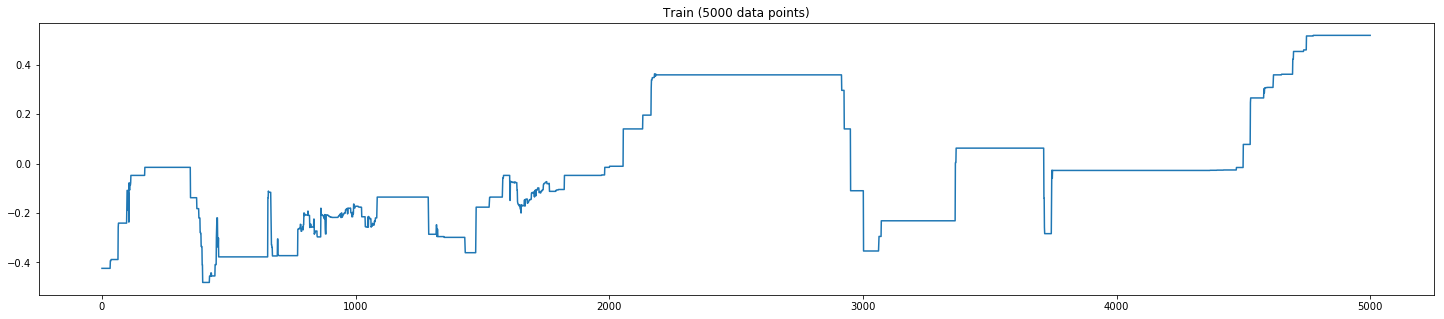

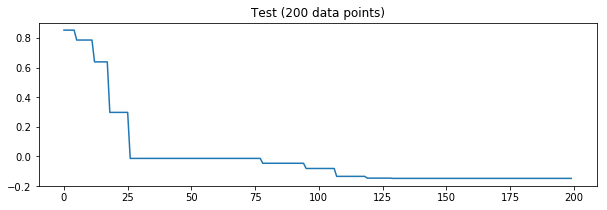

In [15]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders

In [16]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [17]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [18]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [19]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [20]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [21]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [22]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [23]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [24]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\Users\Jason\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [25]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 200 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 4.056830
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000006
Epoch 1
Step 0 - Loss: 0.016570
Step 200 - Loss: 0.000050
Step 400 - Loss: 0.000000
Epoch 2
Step 0 - Loss: 0.018289
Step 200 - Loss: 0.000073
Step 400 - Loss: 0.000003
Epoch 3
Step 0 - Loss: 0.029917
Step 200 - Loss: 0.000034
Step 400 - Loss: 0.000014
Epoch 4
Step 0 - Loss: 0.033344
Step 200 - Loss: 0.000017
Step 400 - Loss: 0.000055
Epoch 5
Step 0 - Loss: 0.034682
Step 200 - Loss: 0.000004
Step 400 - Loss: 0.000093
Epoch 6
Step 0 - Loss: 0.027835
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000078
Epoch 7
Step 0 - Loss: 0.026797
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000055
Epoch 8
Step 0 - Loss: 0.025539
Step 200 - Loss: 0.000007
Step 400 - Loss: 0.000042
Epoch 9
Step 0 - Loss: 0.022637
Step 200 - Loss: 0.000013
Step 400 - Loss: 0.000027
Epoch 10
Step 0 - Loss: 0.020696
Step 200 - Loss: 0.000024
Step 400 - Loss: 0.000013
Epoch 11
Step 0 - Loss: 0.018089
Step 200 - Loss: 0.000040
Step 400 - Loss:

Step 400 - Loss: 0.000001
Epoch 97
Step 0 - Loss: 0.008475
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000001
Epoch 98
Step 0 - Loss: 0.006849
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000001
Epoch 99
Step 0 - Loss: 0.008717
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000000


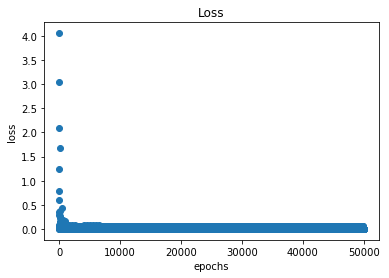

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

#### Denormalize

In [27]:
test_pred_list[:] = [(x*PriceRange)+PriceMean for x in test_pred_list]
yTest[:] = [(x*PriceRange)+PriceMean for x in yTest]

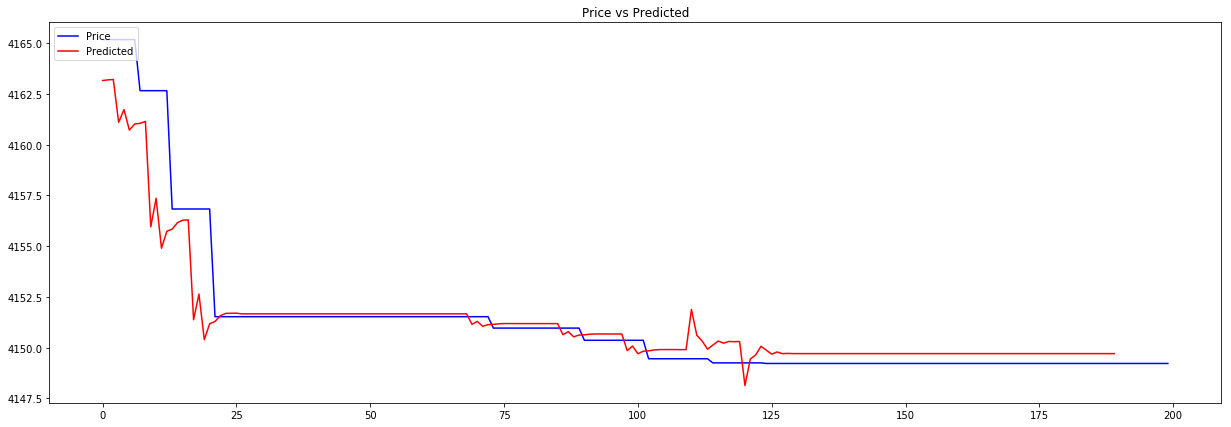

In [28]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

In [29]:
len(test_pred_list)

190

In [30]:
predict= pd.DataFrame(test_pred_list, columns=['Prediction'])

In [31]:
real = pd.DataFrame(yTest, columns=['Price'])

In [32]:
realVSpredict = predict.join(real)

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(realVSpredict)

      Prediction        Price
0    4163.155181  4165.172362
1    4163.187534  4165.172362
2    4163.206428  4165.172362
3    4161.099178  4165.172362
4    4161.723397  4165.172362
5    4160.715010  4165.172362
6    4161.018405  4165.172362
7    4161.045413  4162.655979
8    4161.143176  4162.655979
9    4155.951311  4162.655979
10   4157.355237  4162.655979
11   4154.898204  4162.655979
12   4155.731346  4162.655979
13   4155.840812  4156.829583
14   4156.157985  4156.829583
15   4156.282469  4156.829583
16   4156.291629  4156.829583
17   4151.376174  4156.829583
18   4152.640927  4156.829583
19   4150.393313  4156.829583
20   4151.178484  4156.829583
21   4151.289802  4151.525821
22   4151.575273  4151.525821
23   4151.688761  4151.525821
24   4151.695277  4151.525821
25   4151.698948  4151.525821
26   4151.666394  4151.525821
27   4151.666394  4151.525821
28   4151.666394  4151.525821
29   4151.666394  4151.525821
30   4151.666394  4151.525821
31   4151.666394  4151.525821
32   4151.